In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, DataCollatorForLanguageModeling, get_cosine_schedule_with_warmup
from datasets import load_dataset

from attentif.mini_bert import MaskedLM

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
warmup_step_ratio = 0.1
num_epochs = 20
batch_size = 32
max_length = 512

In [3]:
dataset = load_dataset("allenai/c4", "realnewslike", split="train[:10000]")
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
collator = DataCollatorForLanguageModeling(tokenizer)

dataset = dataset.map(
    lambda examples: tokenizer(
        examples["text"],
        truncation=True,
        max_length=max_length,
    ),
    remove_columns=dataset.column_names,
    batched=True,
);

batches = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collator)

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/512 [00:00<?, ?it/s]

In [4]:
model = MaskedLM(tokenizer.vocab_size, tokenizer.pad_token_id)
device = torch.device("mps")
model = model.to(device)

In [5]:
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.0)

num_training_steps = num_epochs * len(batches)
num_warmup_steps = int(num_training_steps * warmup_step_ratio)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_training_steps=num_training_steps,
    num_warmup_steps=num_warmup_steps,
)

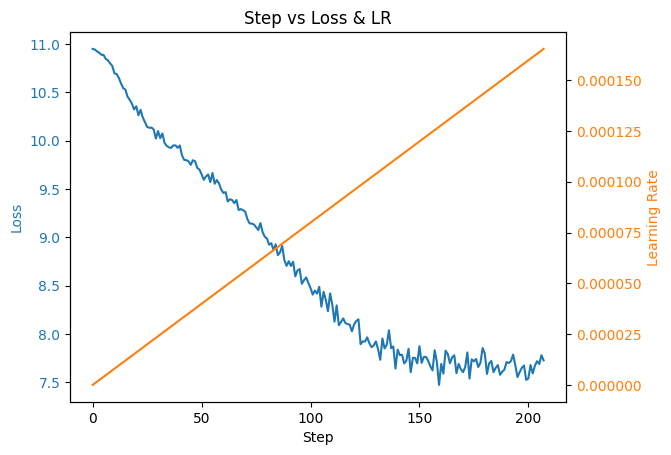

  0%|                                                                                                                                                                                | 0/20 [09:25<?, ?it/s]


KeyboardInterrupt: 

In [6]:
model.train()

losses = []
lrs = []

def visualize():
    clear_output(wait=True)
    
    fig, ax1 = plt.subplots()
    
    # 左軸: loss
    ax1.plot(losses, color="tab:blue")
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Loss", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    
    # 右軸: learning rate
    ax2 = ax1.twinx()
    ax2.plot(lrs, color="tab:orange")
    ax2.set_ylabel("Learning Rate", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    
    plt.title("Step vs Loss & LR")
    plt.show()

for epoch in tqdm(range(0, num_epochs)):
    for batch in batches:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # 1/0 を 0/-1e9 に変換
        attention_mask = torch.where(attention_mask == 1, 0.0, -1e9)

        logits = model(input_ids, attention_mask)
        loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))

        optimizer.zero_grad(set_to_none=True)
        loss.backward()

        lrs.append(optimizer.param_groups[0]["lr"]) 
        
        optimizer.step()
        scheduler.step()

        if len(losses) == 0:
            print("=== Diagnostic Info ===")
            print(f"Attention mask shape: {attention_mask.shape}")
            print(f"Attention mask sample (first seq): {attention_mask[0, :20]}")
            print(f"Attention mask unique values: {attention_mask.unique()}")
            print(f"Input IDs sample: {input_ids[0, :20]}")
            print(f"Labels sample: {labels[0, :20]}")
            print(f"\n=== Model Internals ===")
            print(f"Embeddings norm: {model.E.norm().item()}")
            print(f"Embeddings sample: {model.E[0, :5]}")
    
            # モデルの出力をチェック
            with torch.no_grad():
                print(f"Logits max: {logits.max().item()}, min: {logits.min().item()}")
                print(f"Logits mean: {logits.mean().item()}")

        if len(losses) == 1:  # 1ステップ後
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    total_norm += p.grad.norm().item() ** 2
            total_norm = total_norm ** 0.5
            print(f"\nGradient norm (step 1): {total_norm}")
    
        losses.append(loss.item())

        visualize()


In [8]:
print(dict([ (idx, "{:.2f}".format(v)) for (idx, v) in enumerate(losses) if idx % 10 == 0 ]))

{0: '10.95', 10: '10.70', 20: '10.36', 30: '10.10', 40: '9.95', 50: '9.65', 60: '9.46', 70: '9.27', 80: '8.99', 90: '8.75', 100: '8.47', 110: '8.30', 120: '8.10', 130: '7.92', 140: '7.84', 150: '7.87', 160: '7.69', 170: '7.60', 180: '7.80', 190: '7.71', 200: '7.54'}
